# Dyna-style Methods: Customized Mountain Car

# Helper Functions (Discretization & SARSA Logic)

In [2]:
import sys

# Add the parent directory of your .py file to sys.path
sys.path.insert(0, '/kaggle/input/rl-hw4-lib')

# Optional: print to verify
print("Updated sys.path:")
print(sys.path)

Updated sys.path:
['/kaggle/input/rl-hw4-lib', '/kaggle/input/rl-hw4-lib', '/kaggle/working', '/kaggle/lib/kagglegym', '/kaggle/lib', '/usr/lib/python312.zip', '/usr/lib/python3.12', '/usr/lib/python3.12/lib-dynload', '', '/usr/local/lib/python3.12/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.12/dist-packages/IPython/extensions', '/root/.ipython']


In [9]:
import numpy as np

# --- Helper Functions (Same as before) ---
N_BINS = 100
X_BOUNDS = [-7.0, 10.0]
V_BOUNDS = [-15.0, 15.0]
ACTIONS = [0, 1, 2]

def discretize(state):
    x, v = state
    x_idx = int((x - X_BOUNDS[0]) / (X_BOUNDS[1] - X_BOUNDS[0]) * N_BINS)
    v_idx = int((v - V_BOUNDS[0]) / (V_BOUNDS[1] - V_BOUNDS[0]) * N_BINS)
    return max(0, min(N_BINS-1, x_idx)), max(0, min(N_BINS-1, v_idx))

def get_action(state_idx, Q, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(ACTIONS)
    return np.argmax(Q[state_idx[0], state_idx[1]])

def run_episode_n_step_sarsa(env, Q, alpha, gamma, n_step, epsilon, planning_steps=0, sim_env=None):
    """
    Runs one episode using n-step SARSA with optional Dyna-Q planning.
    """
    state = env.reset()
    s_idx = discretize(state)
    action = get_action(s_idx, Q, epsilon)
    
    # Store transitions
    states = [s_idx]
    actions = [action]
    rewards = [0.0] # Dummy value at index 0 to align indices (R_1 is at index 1)
    
    total_reward = 0
    t = 0
    T = float('inf')
    
    while True:
        if t < T:
            # 1. Take Step
            step_result = env.step(action)
            
            # Handle variable return length
            if len(step_result) == 4:
                next_state, reward, done, _ = step_result
            else:
                next_state, reward, done = step_result
            
            # --- FIX: Append reward immediately, regardless of done status ---
            rewards.append(reward)
            total_reward += reward
            # ---------------------------------------------------------------
            
            if done:
                T = t + 1
            else:
                ns_idx = discretize(next_state)
                next_action = get_action(ns_idx, Q, epsilon)
                states.append(ns_idx)
                actions.append(next_action)
                action = next_action 
        
        # 2. n-step SARSA Update
        tau = t - n_step + 1
        if tau >= 0:
            G = 0
            # Sum discounted rewards
            for i in range(tau + 1, min(tau + n_step, T) + 1):
                G += (gamma ** (i - tau - 1)) * rewards[i]
            
            # Add bootstrap value if not terminal
            if tau + n_step < T:
                s_n = states[tau + n_step]
                a_n = actions[tau + n_step]
                G += (gamma ** n_step) * Q[s_n[0], s_n[1], a_n]
            
            # Update Q
            s_tau = states[tau]
            a_tau = actions[tau]
            Q[s_tau[0], s_tau[1], a_tau] += alpha * (G - Q[s_tau[0], s_tau[1], a_tau])

        # 3. Dyna-Q Planning
        # Only if planning is enabled, sim_env exists, and we have history to sample from
        if planning_steps > 0 and sim_env is not None and hasattr(env, 'visited_states') and len(env.visited_states) > 0:
            for _ in range(planning_steps):
                # a. Sample
                sample = env.sample()
                if sample is None: continue
                s_plan_raw, a_plan = sample
                s_plan_idx = discretize(s_plan_raw)
                
                # b. Predict
                predict_result = sim_env.predict(s_plan_raw, a_plan)
                if len(predict_result) == 3:
                     s_next_raw, r_plan, d_plan = predict_result
                else:
                     s_next_raw, r_plan, d_plan, _ = predict_result

                s_next_idx = discretize(s_next_raw)
                
                # c. Update (1-step Q-learning)
                best_next_a = np.argmax(Q[s_next_idx[0], s_next_idx[1]])
                td_target = r_plan + gamma * Q[s_next_idx[0], s_next_idx[1], best_next_a]
                current_q = Q[s_plan_idx[0], s_plan_idx[1], a_plan]
                
                Q[s_plan_idx[0], s_plan_idx[1], a_plan] += alpha * (td_target - current_q)

        if tau == T - 1:
            break
            
        t += 1
        
    return total_reward

# Part 1: Manual Play

In [ ]:
# # To play manually:
# if __name__ == "__main__":
#     # Change extra_curve to True to test the two-hills
#     env = CustomMountainCar(extra_curve=True, extra_const=3.0)
#     print("Controls: A (Left), D (Right). Q to quit.")
#     # env.play_with_pygame() # Uncomment to run locally

# Part 2: n-step SARSA on Standard Curve

--- Starting Part 2: Training on Standard Curve ---
Episode 500: Reward -1002.00, Epsilon 0.779
Episode 1000: Reward -1002.00, Epsilon 0.606
Episode 1500: Reward -1002.00, Epsilon 0.472
Episode 2000: Reward -1002.00, Epsilon 0.368
Episode 2500: Reward -810.00, Epsilon 0.286
Episode 3000: Reward -1002.00, Epsilon 0.223
Episode 3500: Reward -786.00, Epsilon 0.174
Episode 4000: Reward -953.00, Epsilon 0.135
Episode 4500: Reward -838.00, Epsilon 0.105
Episode 5000: Reward -636.00, Epsilon 0.082
Episode 5500: Reward -731.00, Epsilon 0.064
Episode 6000: Reward -596.00, Epsilon 0.050
Episode 6500: Reward -470.00, Epsilon 0.050
Episode 7000: Reward -475.00, Epsilon 0.050
Episode 7500: Reward -416.00, Epsilon 0.050
Episode 8000: Reward -337.00, Epsilon 0.050
Episode 8500: Reward -370.00, Epsilon 0.050
Episode 9000: Reward -333.00, Epsilon 0.050
Episode 9500: Reward -339.00, Epsilon 0.050
Episode 10000: Reward -335.00, Epsilon 0.050


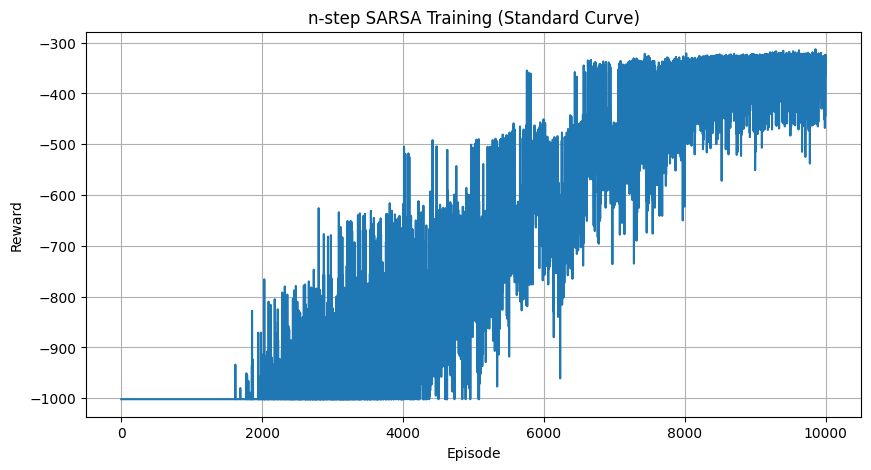

In [11]:
import matplotlib.pyplot as plt
from CustomMountainCar import CustomMountainCar

def train_standard_sarsa():
    print("--- Starting Part 2: Training on Standard Curve ---")
    # Initialize your environment
    env = CustomMountainCar(extra_curve=False)
    
    Q = np.zeros((N_BINS, N_BINS, 3))
    
    # Hyperparameters from Part 2 description
    alpha = 0.1
    gamma = 0.99
    n_step = 5
    episodes = 10000 
    
    epsilon = 1.0
    epsilon_min = 0.05
    epsilon_decay = 0.9995
    
    rewards_history = []
    
    for ep in range(episodes):
        total_r = run_episode_n_step_sarsa(env, Q, alpha, gamma, n_step, epsilon)
        rewards_history.append(total_r)
        
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        
        if (ep+1) % 500 == 0:
            print(f"Episode {ep+1}: Reward {total_r:.2f}, Epsilon {epsilon:.3f}")
            
    return Q, rewards_history

# Run Training
Q_standard, rewards_standard = train_standard_sarsa()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(rewards_standard)
plt.title("n-step SARSA Training (Standard Curve)")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.show()

# Part 3: Dyna-Q Transfer Learning

Training with planning_steps=0...
Ep 100: Reward -1002.0
Ep 200: Reward -1002.0
Ep 300: Reward -1002.0
Ep 400: Reward -1002.0
Ep 500: Reward -834.0
Ep 600: Reward -1002.0
Ep 700: Reward -1002.0
Ep 800: Reward -988.0
Ep 900: Reward -982.0
Ep 1000: Reward -989.0
Ep 1100: Reward -1002.0
Ep 1200: Reward -803.0
Ep 1300: Reward -935.0
Ep 1400: Reward -1002.0
Ep 1500: Reward -973.0
Ep 1600: Reward -1002.0
Ep 1700: Reward -990.0
Ep 1800: Reward -1002.0
Ep 1900: Reward -912.0
Ep 2000: Reward -1002.0
Ep 2100: Reward -1002.0
Ep 2200: Reward -821.0
Ep 2300: Reward -878.0
Ep 2400: Reward -1002.0
Ep 2500: Reward -908.0
Ep 2600: Reward -997.0
Ep 2700: Reward -910.0
Ep 2800: Reward -1002.0
Ep 2900: Reward -833.0
Ep 3000: Reward -684.0
Ep 3100: Reward -959.0
Ep 3200: Reward -976.0
Ep 3300: Reward -1002.0
Ep 3400: Reward -790.0
Ep 3500: Reward -795.0
Ep 3600: Reward -1002.0
Ep 3700: Reward -1002.0
Ep 3800: Reward -984.0
Ep 3900: Reward -922.0
Ep 4000: Reward -983.0
Ep 4100: Reward -768.0
Ep 4200: Reward

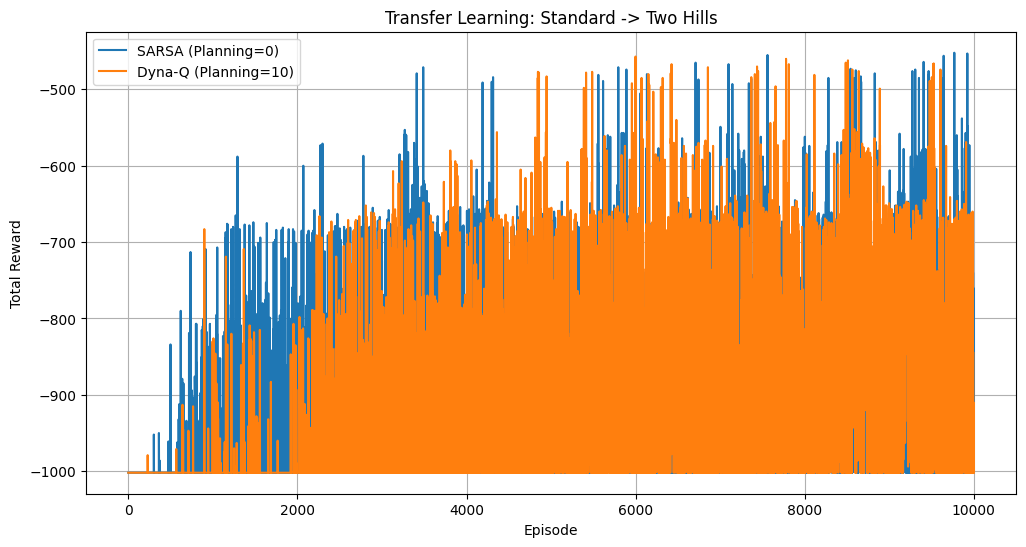

In [13]:
def train_dyna_transfer(initial_Q, planning_steps=0):
    env_real = CustomMountainCar(extra_curve=True, extra_const=3.0)
    sim_env = CustomMountainCar(extra_curve=False) # Simulator uses standard curve
    
    # Copy initial Q to avoid overwriting
    Q = np.copy(initial_Q)
    
    # Hyperparameters (Part 3)
    alpha = 0.5
    gamma = 0.99
    n_step = 5
    episodes = 10000
    
    epsilon = 1.0
    epsilon_min = 0.05
    epsilon_decay = 0.995
    
    rewards_history = []
    
    print(f"Training with planning_steps={planning_steps}...")
    
    for ep in range(episodes):
        # We pass sim_env only if we are doing planning
        r = run_episode_n_step_sarsa(env_real, Q, alpha, gamma, n_step, epsilon, 
                                     planning_steps=planning_steps, sim_env=sim_env)
        rewards_history.append(r)
        
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        
        if (ep+1) % 100 == 0:
            print(f"Ep {ep+1}: Reward {r:.1f}")
            
    return rewards_history, Q

# 1. Run SARSA (Planning = 0)
rewards_sarsa_transfer, Q_sarsa_final = train_dyna_transfer(Q_standard, planning_steps=0)

# 2. Run Dyna-Q (Planning = 10)
rewards_dynaq_transfer, Q_dynaq_final = train_dyna_transfer(Q_standard, planning_steps=10)

# 3. Plot Comparison
plt.figure(figsize=(12, 6))
plt.plot(rewards_sarsa_transfer, label='SARSA (Planning=0)')
plt.plot(rewards_dynaq_transfer, label='Dyna-Q (Planning=10)')
plt.title("Transfer Learning: Standard -> Two Hills")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.grid(True)
plt.show()

# Video Generation

Generating Standard Curve Video...
Video saved successfully: sarsa_policy_test_env.mp4
Generating Two Hills Video...
Video saved successfully: dyna_policy_two_hill.mp4


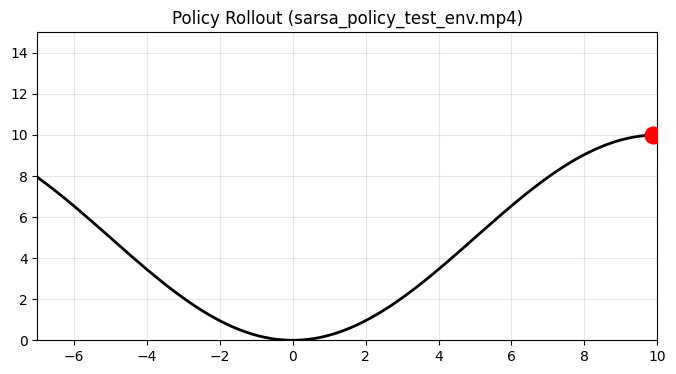

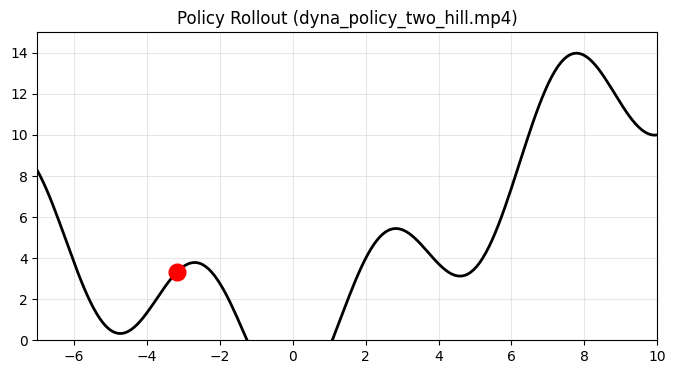

In [16]:
def save_agent_video(env, Q, filename="agent_run.mp4"):
    # --- Helper: Re-implement Eq 3 for Visualization ---
    def local_get_height(x, extra_curve, c):
        # Base Hill: 5 * sin(pi*x/10 - pi/2) + 5
        h = 5 * np.sin(np.pi * x / 10 - np.pi / 2) + 5
        
        # Second Hill (if enabled): c * (sin(4*pi*x/10 - pi/2) + x/10)
        if extra_curve:
            h += c * (np.sin(4 * np.pi * x / 10 - np.pi / 2) + x / 10)
        return h
    
    # Check attributes to handle naming differences in provided class
    is_extra = getattr(env, 'extra_curve', False)
    # Try to find the constant 'c' or 'extra_const'
    c_val = getattr(env, 'extra_const', 3.0) 
    if hasattr(env, 'c'): c_val = env.c
        
    state = env.reset()
    frames = []
    
    # 1. Setup the Plot
    fig, ax = plt.subplots(figsize=(8,4))
    
    # Generate Terrain Line
    x_min, x_max = -7.0, 10.0 # From prompt physical parameters
    xs = np.linspace(x_min, x_max, 200)
    ys = [local_get_height(x, is_extra, c_val) for x in xs]
    
    done = False
    max_steps = 400
    steps = 0
    
    # 2. Run Episode & Capture Frames
    while not done and steps < max_steps:
        s_idx = discretize(state)
        action = np.argmax(Q[s_idx[0], s_idx[1]])
        
        # Handle variable return format (3 or 4 values)
        step_result = env.step(action)
        if len(step_result) == 4:
            state, _, done, _ = step_result
        else:
            state, _, done = step_result
        
        # Capture frame data (Car X position, Car Y height)
        car_x = state[0]
        car_y = local_get_height(car_x, is_extra, c_val)
        frames.append((car_x, car_y))
        steps += 1
    
    plt.close()
    
    # 3. Create Animation
    fig2, ax2 = plt.subplots(figsize=(8,4))
    ax2.plot(xs, ys, 'k-', lw=2) # Terrain
    dot, = ax2.plot([], [], 'ro', markersize=12, zorder=5) # Car
    
    ax2.set_xlim(x_min, x_max)
    ax2.set_ylim(0, 15)
    ax2.set_title(f"Policy Rollout ({filename})")
    ax2.grid(True, alpha=0.3)
    
    def update(frame_idx):
        x, y = frames[frame_idx]
        dot.set_data([x], [y])
        return dot,
        
    ani = animation.FuncAnimation(fig2, update, frames=len(frames), blit=True)
    ani.save(filename, writer='ffmpeg', fps=30)
    print(f"Video saved successfully: {filename}")

# --- Execute Video Generation ---
# Note: Ensure Q_standard and Q_dynaq_final are computed from previous steps

# 1. Video for Standard SARSA Policy (Standard Curve)
print("Generating Standard Curve Video...")
save_agent_video(CustomMountainCar(extra_curve=False), Q_standard, "sarsa_policy_test_env.mp4")

# 2. Video for Dyna-Q Policy (Two Hills Curve)
print("Generating Two Hills Video...")
save_agent_video(CustomMountainCar(extra_curve=True, extra_const=3.0), Q_dynaq_final, "dyna_policy_two_hill.mp4")